# Retrieval-Augmented Generation

## Einführung

In diesem Notebook wird eine Retrieval-Augmented Generation (RAG) für die *Magpie* implementiert. Ziel ist es, einen Chatbot zu erstellen, der Fragen in natürlicher Sprache entgegennimmt und diese in passende SQL-Abfragen umwandelt und wiederum in natürlicher Sprache antwortet.

Um die SQL-Abfragen genau auf die Daten von Magpie abzustimmen, wird auf Basis dieses [Tutorials](https://python.langchain.com/docs/tutorials/sql_qa/#system-prompt) und mit Langchain ein Chatbot erzeugt, der mit einem Retriever-Tool arbeitet. Der Chatbot unterscheidet sich im Vorgehen von einer *normalen* RAG: Während bei einer RAG üblicherweise Text generiert wird (die Anfrage durch einen User), der gegen eine Vektordatenbank durchsucht werden kann, besteht der Ansatz für strukturierte Daten darin, dass das LLM SQL-Abfragen schreibt und ausführt.

## Durchführung

### Arbeitspfad definieren

In einem ersten Schritt definieren wir unseren Arbeitspfad:

In [31]:
# Aktuelles Arbeitsverzeichnis ermitteln
import os
os.getcwd()
os.chdir("c:/Users/Hueck/OneDrive/Dokumente/GitHub/magpie_langchain")

### LLM laden

In einem weiteren Schritt laden wir ein LLM. Das LLM wandelt die Anfrage des Users in eine SQL-Abfrage um und antwortet basierend auf den Ergebnissen der Abfrage in natürlicher Sprache. Das sich `llama3.1:8b-instruct-q4_0` nicht so leistungsfähig wie `gpt-4o-mini` im Kontext der Generierung der SQL-Abfragen erwiesen hat, wird vorerst mit einer OpenAI-API gearbeitet. Sie wird im folgenden aus dem Environment geladen um auf `gpt-4o-mini` zugreifen zu können. Der Code importiert weiterhin die `ChatOpenAI`-Klasse aus dem Modul `langchain_openai`, welches die Nutzung von OpenAI-Modellen vereinfacht. Anschließend wird ein Objekt `llm` vom Typ `ChatOpenAI` erstellt, wobei das Modell `"gpt-4o-mini"` angegeben wird.

In [32]:
from dotenv import load_dotenv

# Lade Umgebungsvariablen aus der .env Datei
load_dotenv()

from langchain_openai import ChatOpenAI
llm = ChatOpenAI(model="gpt-4o-mini")

# from langchain_ollama import ChatOllama
# llm = ChatOllama(model="qwen2.5:32b", temperature=0)

### Tools genieren

Wir erstellen nun ein Set von `tools`. Das `SQLDatabaseToolkit` umfasst in diesem Kontext Werkzeuge, die uns dabei unterstützen, SQL-Abfragen zu erstellen und auszuführen sowie die Syntax von SQL-Abfragen zu überprüfen. 

Es wird dafür eine Instanz von `SQLDatabase` erstellt, um Interaktionen mit der Datenbank zu ermöglichen. Nach der Einrichtung der Datenbank wird eine Instanz von `SQLDatabaseToolkit` erstellt, die zwei Argumente benötigt: die zuvor erstellte `db`-Instanz und die oben definierte `llm` (Sprachmodell)-Instanz (siehe oben). Das Toolkit nutzt das Sprachmodell für Aufgaben wie die Validierung von Abfragen.

Die Methode `get_tools` der `SQLDatabaseToolkit`-Instanz wird dann aufgerufen, um eine Liste der verfügbaren Werkzeuge im Toolkit abzurufen. Diese Werkzeuge umfassen Funktionen wie das Auflisten von Datenbanktabellen, das Abrufen von Schema-Informationen, das Ausführen von SQL-Abfragen und das Überprüfen der Korrektheit von SQL-Abfragen. Die letzte Zeile des Codes gibt die Liste der Werkzeuge aus, sodass der Benutzer die verfügbaren Werkzeuge und deren Beschreibungen einsehen kann.

In [33]:
from langchain_community.agent_toolkits import SQLDatabaseToolkit
from langchain_community.utilities import SQLDatabase

db = SQLDatabase.from_uri("duckdb:///data/magpie.db")
toolkit = SQLDatabaseToolkit(db=db, llm=llm)

tools = toolkit.get_tools()

print(tools)

[QuerySQLDataBaseTool(description="Input to this tool is a detailed and correct SQL query, output is a result from the database. If the query is not correct, an error message will be returned. If an error is returned, rewrite the query, check the query, and try again. If you encounter an issue with Unknown column 'xxxx' in 'field list', use sql_db_schema to query the correct table fields.", db=<langchain_community.utilities.sql_database.SQLDatabase object at 0x000002A756BFA070>), InfoSQLDatabaseTool(description='Input to this tool is a comma-separated list of tables, output is the schema and sample rows for those tables. Be sure that the tables actually exist by calling sql_db_list_tables first! Example Input: table1, table2, table3', db=<langchain_community.utilities.sql_database.SQLDatabase object at 0x000002A756BFA070>), ListSQLDatabaseTool(db=<langchain_community.utilities.sql_database.SQLDatabase object at 0x000002A756BFA070>), QuerySQLCheckerTool(description='Use this tool to dou

c:\Users\Hueck\miniconda3\envs\RAG_retriever\lib\site-packages\duckdb_engine\__init__.py:174: DuckDBEngineWarning: duckdb-engine doesn't yet support reflection on indices
  warnings.warn(


### Prompt Template generieren 

In diesem Code wird das `langchain`-Paket verwendet, um ein Prompt-Template von `langchain-ai` zu laden und zu überprüfen. Zuerst wird die `hub`-Funktion aus dem `langchain`-Paket importiert, um auf Modelle und Vorlagen im LangChain Hub zuzugreifen. Mit `hub.pull("langchain-ai/sql-agent-system-prompt")` wird ein spezifisches Prompt-Template abgerufen, in diesem Fall das `sql-agent-system-prompt`. `sql-agent-system-prompt` ist ein vordefiniertes Prompt-Template. Es dient als Vorlage für die Interaktion mit einer SQL-Datenbank über ein Sprachmodell. Dieses Template ist speziell für die Verwendung mit SQL-Agenten konzipiert, die SQL-Abfragen generieren oder validieren können.

Der Code prüft weiterhin mit `assert len(prompt_template.messages) == 1`, ob das geladene Template genau eine Nachricht enthält. Falls dies nicht zutrifft, wird ein Abbruch ausgelöst. Abschließend wird mit `prompt_template.messages[0].pretty_print()` die Nachricht im Template in einem gut lesbaren Format ausgegeben, um sicherzustellen, dass der Inhalt korrekt geladen wurde.

In [34]:
from langchain import hub

prompt_template = hub.pull("langchain-ai/sql-agent-system-prompt")

assert len(prompt_template.messages) == 1, "Die Anzahl der Nachrichten im Template ist nicht 1!"
# Bearbeite die bestehende Nachricht, indem du Text hinzufügst
prompt_template.messages[0].prompt.template += (
    "\nYou are Sparklehorse, a chatbot for the Stifterverband organization. "
    "Your primary task is to answer questions related to the Magpie database."
)

prompt_template.messages[0].pretty_print()

c:\Users\Hueck\miniconda3\envs\RAG_retriever\lib\site-packages\langsmith\client.py:261: LangSmithMissingAPIKeyWarning: API key must be provided when using hosted LangSmith API
  warnings.warn(


================================ System Message ================================

You are an agent designed to interact with a SQL database.
Given an input question, create a syntactically correct {dialect} query to run, then look at the results of the query and return the answer.
Unless the user specifies a specific number of examples they wish to obtain, always limit your query to at most {top_k} results.
You can order the results by a relevant column to return the most interesting examples in the database.
Never query for all the columns from a specific table, only ask for the relevant columns given the question.
You have access to tools for interacting with the database.
Only use the below tools. Only use the information returned by the below tools to construct your final answer.
You MUST double check your query before executing it. If you get an error while executing a query, rewrite the query and try again.

DO NOT make any DML statements (INSERT, UPDATE, DELETE, DROP etc.) to th

Wir befüllen nun die Objekte, die in `prompt_template` bisher nur als Platzhalter definiert sind. Diese sind:
1. `dialect`
2. `top_k`

 `dialect` meint den SQL-Dialekt der verwendeten Datenbank. `top_k` bestimmt die Anzahl der zurückgegebenen, *besten Ergebnisse*. In diesem Kontext bedeutet *beste Ergebnisse* die Auswahl der relevantesten oder nützlichsten Ergebnisse der Abfragen, etwa bzgl. der Relevanz im Zusammenhang mit einer Abfrage.


In [35]:
system_message = prompt_template.format(
    dialect=db.dialect, 
    top_k=5
)

print(system_message)


System: You are an agent designed to interact with a SQL database.
Given an input question, create a syntactically correct duckdb query to run, then look at the results of the query and return the answer.
Unless the user specifies a specific number of examples they wish to obtain, always limit your query to at most 5 results.
You can order the results by a relevant column to return the most interesting examples in the database.
Never query for all the columns from a specific table, only ask for the relevant columns given the question.
You have access to tools for interacting with the database.
Only use the below tools. Only use the information returned by the below tools to construct your final answer.
You MUST double check your query before executing it. If you get an error while executing a query, rewrite the query and try again.

DO NOT make any DML statements (INSERT, UPDATE, DELETE, DROP etc.) to the database.

To start you should ALWAYS look at the tables in the database to see w

### Agent generieren    

Es wird nun eine Instanz eines *React-Agenten* aus der `langchain_core` und `langgraph` Bibliothek erstellt und konfiguriert. Im einzelnen passiert das Folgende: Die Funktion `create_react_agent(llm, tools, state_modifier=system_message)` erstellt einen neuen Agenten, der auf das bereitgestellte Sprachmodell (`llm`) und eine Sammlung von Werkzeugen (`tools`) zugreifen kann, um Aufgaben zu erledigen. Das Sprachmodell (`llm`) ist die Instanz eines Modells `gpt-4o-mini`, das vom Agenten verwendet wird, während tools die Werkzeuge sind, mit denen der Agent auf Daten zugreifen oder Aktionen durchführen kann, zum Beispiel eine SQL-Datenbankabfrage oder APIs. `state_modifier=system_message` gibt eine Systemnachricht an, die die Rolle des Agenten und seine Aufgaben innerhalb des Systems beschreibt, einschließlich der Anweisungen, wie der Agent mit den Eingaben des Benutzers umgehen soll. Die erstellte Instanz des React-Agenten wird in der Variablen `agent_executor` gespeichert, die dann verwendet wird, um Interaktionen mit einem Benutzer zu führen und die entsprechenden Werkzeuge anzuwenden.

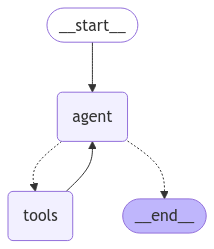

In [41]:
from langchain_core.messages import HumanMessage
from langgraph.prebuilt import create_react_agent

agent_executor = create_react_agent(llm, tools, state_modifier=system_message)
agent_executor

### Retriever Tool

Im folgenden wird ein Retriever-Tool erzeugt, dass dabei hilft, *fehlerhafte* Abfragen seitens der User zu korrigieren. Das Retriever Tool versteht so z.B. dass "*"Frei Uni Nerlin"*" für "*Freie Universität Berlin*" steht.

Zunächst werden die benötigten Bibliotheken importiert. LangChain-Module werden verwendet, um Embeddings und einen In-Memory-Vektorspeicher zu erstellen. Zudem werden `ast` und `re` für die Verarbeitung und Bereinigung von Daten genutzt.

Die Funktion `query_as_list(db, query)` führt eine SQL-Abfrage auf Magpie `db` aus. Das Ergebnis wird zunächst in eine Liste umgewandelt, dabei werden verschachtelte Strukturen aufgelöst. Danach werden alle Zahlen aus den Ergebnissen entfernt, und Leerzeichen werden bereinigt. Schließlich wird sichergestellt, dass nur eindeutige Werte in der Liste enthalten sind.

Anschließend werden mit `query_as_list` zwei Listen erstellt:  
- `Variable`, die alle Werte aus der Spalte *Variable* der Tabelle `datensatz_drittmittel_hochschule` enthält.  
- `Hochschule`, die alle Werte aus der Spalte *Hochschule* derselben Tabelle enthält.  

Nun wird ein Embedding-Modell von OpenAI mit dem Namen `"text-embedding-3-large"` initialisiert. Dieses Modell wandelt Texte in numerische Vektoren um, die für eine semantische Suche genutzt werden können.

Ein In-Memory-Vektorspeicher wird erstellt, der diese Vektoren speichert. Anschließend werden die Begriffe aus `Variable` und `Hochschule` als Texte in den Vektorspeicher hinzugefügt.

Der Vektorspeicher wird nun als Retriever konfiguriert. Der Parameter `search_kwargs={"k": 5}` bedeutet, dass für jede Suchanfrage die fünf ähnlichsten Einträge zurückgegeben werden.

Zuletzt wird mit `create_retriever_tool` ein Retriever-Tool erstellt. Dieses Tool kann verwendet werden, um nach ähnlichen Namen oder Begriffen zu suchen. Die Beschreibung des Tools gibt an, dass es dazu dient, gültige Namen zu finden, die am besten zu einer unscharfen Eingabe passen.

In [42]:
from langchain_openai import OpenAIEmbeddings
from langchain_core.vectorstores import InMemoryVectorStore
from langchain.agents.agent_toolkits import create_retriever_tool
import ast
import re


def query_as_list(db, query):
    res = db.run(query)
    res = [el for sub in ast.literal_eval(res) for el in sub if el]
    res = [re.sub(r"\b\d+\b", "", string).strip() for string in res]
    return list(set(res))


Variable = query_as_list(db, "SELECT Variable FROM datensatz_drittmittel_hochschule ")
Hochschule = query_as_list(db, "SELECT Hochschule FROM datensatz_drittmittel_hochschule ")

print(Hochschule)


embeddings = OpenAIEmbeddings(model="text-embedding-3-large")

vector_store = InMemoryVectorStore(embeddings)

_ = vector_store.add_texts(Variable + Hochschule)
retriever = vector_store.as_retriever(search_kwargs={"k": 5})
description = (
    "Use to look up values to filter on. Input is an approximate spelling "
    "of the proper noun, output is valid proper nouns. Use the noun most "
    "similar to the search."
)

retriever_tool = create_retriever_tool(
    retriever,
    name="search_proper_nouns",
    description=description,
)

['Hochschule für angewandte Wissenschaften Würzburg-Schweinfurt', 'Universität Paderborn', 'bbw Hochschule', 'Hochschule Ostwestfalen-Lippe', 'Medizinische Hochschule Hannover (MHH)', 'Universität Konstanz', 'Philosophisch-Theologische Hochschule Benediktbeuern', 'Touro College Berlin', 'Theologische Fakultät Fulda', 'Fachhochschule Bielefeld', 'Technische Hochschule Köln', 'Hochschule Rhein-Waal', 'praxisHochschule Köln University of Applied Science', 'Hamburger Fern-Hochschule gGmbH', 'Palucca Hochschule für Tanz Dresden', 'Fachhochschule für Rechtspflege Nordrhein-Westfalen', 'EBZ Business School University of Applied Sciences', 'Martin-Luther-Universität Halle-Wittenberg (ohne Klinikum)', 'Fachhochschule für Finanzen Nordrhein-Westfalen', 'Universität der Bundeswehr München (FB Fachhochschulstudiengänge)', 'Kirchliche Hochschule Wuppertal/Bethel Hochschule für Kirche und Diakonie', 'Universität des Saarlandes', 'Theologische Fakultät Paderborn Rektorat', 'Hochschule Bremen', 'Fachh

In [47]:
print(retriever_tool.invoke("Frei Uni Nerlin"))

Freie Universität Berlin

Humboldt-Universität zu Berlin

Technische Universität Berlin

Hochschule für Wirtschaft und Recht Berlin

Berlin International University of Applied Sciences


Wir erzeugen das Objekt `suffix`, das als Anweisung dient. Es weist darauf hin, dass bei der Filterung nach Eigennamen (z. B. Namen von Personen oder Institutionen) das Tool `'search_proper_nouns'` verwendet werden muss, um ähnliche gültige Namen zu finden. Dies verhindert, dass Namen geraten werden.

Anschließend wird diese Anweisung an die bestehende Systemnachricht (`system_message`) angehängt und in der Variable `system` gespeichert.

Das zuvor erstellte `retriever_tool` wird der Liste `tools` hinzugefügt, sodass es vom Agenten genutzt werden kann.

Zum Schluss wird mit `create_react_agent` ein ReAct-Agent erstellt. Dieser nutzt das übergebene LLM (Large Language Model), die Liste der Tools und die modifizierte Systemnachricht, um basierend auf Regeln und Tools fundierte Entscheidungen zu treffen.

In [39]:
# Add to system message
suffix = (
    "If you need to filter on a proper noun like a Name, you must ALWAYS first look up "
    "the filter value using the 'search_proper_nouns' tool! Do not try to "
    "guess at the proper name - use this function to find similar ones."
)

system = f"{system_message}\n\n{suffix}"

tools.append(retriever_tool)

agent = create_react_agent(llm, tools, state_modifier=system)

## Probelauf Chatbot

Schließlich testen wir den Bot: Zunächst wird dafür eine Frage (`question`) definiert: *"Wie hoch waren die Drittmittel der FU Berlin im Jahr 2006 insgesamt?"*. Diese Frage wird später an den Agenten übergeben.

Dann wird eine Schleife (`for step in agent.stream(...)`) gestartet, die den Agenten Schritt für Schritt durch den Verarbeitungsprozess führt.  

- Der Agent erhält die Eingabe als eine Nachricht im Format `{"role": "user", "content": question}`.  
- Das Argument `stream_mode="values"` sorgt dafür, dass die Antwort in einzelnen Schritten ausgegeben wird.  
- Innerhalb der Schleife wird der jeweils letzte Schritt (`step["messages"][-1]`) formatiert und ausgegeben, sodass die Antwort für den Nutzer lesbar bleibt.  

Dadurch wird der Verarbeitungsweg der Antwort des Agenten schrittweise angezeigt.

In [40]:
question = "Wie hoch waren die Drittmittel der FU Nerlin in Jahr 2006 insgesamt"

for step in agent.stream(
    {"messages": [{"role": "user", "content": question}]},
    stream_mode="values",
):
    step["messages"][-1].pretty_print()

================================ Human Message =================================

Wie hoch waren die Drittmittel der FU Nerlin in Jahr 2006 insgesamt
================================== Ai Message ==================================
Tool Calls:
  sql_db_list_tables (call_FVkXmlii9ryJ19YGXtmcGrXL)
 Call ID: call_FVkXmlii9ryJ19YGXtmcGrXL
  Args:
================================= Tool Message =================================
Name: sql_db_list_tables

antwort, chart_options_rules, daten, daten_frage, daten_quelle, daten_reichweite, datensatz_drittmittel_aggregiert, datensatz_drittmittel_hochschule, datensatz_fue_erhebung, datensatz_hbr_report, erhebung, erhebung_frage, erhebung_typ, erklaerung, erklaerung_link, frage, germany_choropleth_federal_states, glossar, kurse, menge, menge_zugehoerig, middle_points_of_ger_federal_states, mview_daten_beschr, mview_daten_id, mview_daten_reichweite_menge, quelle, reichweite, reichweite_klasse, reichweite_typ, stichprobe, studierende, studierende_detail

In [48]:
print(db.run("SHOW TABLES"))  # Prüft, ob "Kassel_University" oder eine andere relevante Tabelle existiert
columns = db.run("PRAGMA table_info(datensatz_drittmittel_hochschule)")
print(columns)  # Schau dir die Struktur an

[('antwort',), ('chart_options_rules',), ('daten',), ('daten_frage',), ('daten_quelle',), ('daten_reichweite',), ('datensatz_drittmittel_aggregiert',), ('datensatz_drittmittel_hochschule',), ('datensatz_fue_erhebung',), ('datensatz_hbr_report',), ('erhebung',), ('erhebung_frage',), ('erhebung_typ',), ('erklaerung',), ('erklaerung_link',), ('frage',), ('germany_choropleth_federal_states',), ('glossar',), ('kurse',), ('menge',), ('menge_zugehoerig',), ('middle_points_of_ger_federal_states',), ('mview_daten_beschr',), ('mview_daten_id',), ('mview_daten_reichweite_menge',), ('quelle',), ('reichweite',), ('reichweite_klasse',), ('reichweite_typ',), ('stichprobe',), ('studierende',), ('studierende_detailliert',), ('tabelle',), ('tag',), ('tag_link',), ('variable',), ('view_daten',), ('view_daten_beschr',), ('view_daten_beschr_string',), ('view_daten_detailed',), ('view_daten_id',), ('view_daten_id_string',), ('view_daten_link',), ('view_daten_reichweite_menge',), ('view_daten_struktur',), ('

In [ ]:
import pandas as pd
import duckdb

conn = duckdb.connect("data/drittmittel_hs.db")
cursor = conn.cursor()
query = "SELECT * FROM datensatz_drittmittel_hochschule;"
df = pd.read_sql(query, conn)
df